# Yelp Review Rating Prediction Using Text
### Tatiana Romanchishina

In [3]:
### libraries
import numpy as np
import pandas as pd
import matplotlib as mpl

import matplotlib.pyplot as plt
%matplotlib inline

from pylab import *
import itertools
import random
import scipy
import six
import re

from __future__ import print_function
from pprint import pprint
import time as time
import seaborn as sns
sns.set()

/home/ubuntu/anaconda2/lib/python2.7/site-packages/pandas/computation/__init__.py:19: UserWarning: The installed version of numexpr 2.4.4 is not supported in pandas and will be not be used

  UserWarning)


#### Connect to Amazon S3 storage and download the file

In [2]:
import boto
import boto.s3.connection
from boto.s3.connection import S3Connection
conn = S3Connection()
bucket = conn.get_bucket('yelp-rest-reviews')
for key in bucket.list():
        print ("{name}\t{size}\t{modified}".format(
                name = key.name,
                size = key.size,
                modified = key.last_modified,
                ))

reviews_all.csv	663830339	2016-05-03T17:35:07.000Z


In [3]:
key = bucket.get_key('reviews_all.csv')
key.get_contents_to_filename('/home/ubuntu/yelp/reviews_all.csv')

### Load the data into a dataframe

In [4]:
path = r'/home/ubuntu/yelp/reviews_all.csv'
reviews = pd.read_csv(path)
reviews['Rating_nom'] = ["one" if Rating == 1 else "two" if Rating == 2 else "three" if Rating == 3 
                else "four" if Rating == 4 else "five" for Rating in reviews.Rating]
reviews = reviews[['Text','Rating_nom']]
reviews.head()

,Text,Rating_nom
0,I was underwhelmed I ordered the filet and i...,two
1,Fun environment friendly staff and decent foo...,four
2,Benjamin s is good bar restaurant on the Nort...,five
3,This place is awesome The food is great and t...,five
4,We loved Eddie and his very appeasing accent ...,five


In [3]:
reviews.shape

(990627, 2)

#### Load the necessary Machine Learning libraries

In [5]:
from sklearn.feature_extraction.text import CountVectorizer
from sklearn.feature_extraction.text import TfidfTransformer

from sklearn.svm import SVC, LinearSVC
from sklearn.naive_bayes import MultinomialNB
from sklearn.neighbors import KNeighborsClassifier
from sklearn.linear_model import LogisticRegression

from sklearn.grid_search import GridSearchCV
from sklearn.pipeline import Pipeline
from sklearn.cross_validation import KFold
from sklearn.metrics import confusion_matrix, f1_score
from sklearn import metrics
from sklearn.cross_validation import train_test_split

#### Helper function for plotting confusion matrix

In [65]:
labels = ["one","two","three","four","five"]

def plot_confusion(confmat):
    fig = plt.figure()
    ax = fig.add_subplot(111)
    cax = ax.matshow(confmat)
    plt.title('Confusion matrix of the classifier')
    fig.colorbar(cax)
    ax.set_xticklabels([''] + labels)
    ax.set_yticklabels([''] + labels)
    plt.xlabel('Predicted')
    plt.ylabel('True')
    plt.show()

             precision    recall  f1-score   support

        one       0.56      0.70      0.62     43983
        two       0.41      0.44      0.43     48605
      three       0.45      0.48      0.47     76837
       four       0.58      0.47      0.52    159890
       five       0.68      0.73      0.70    165999

avg / total       0.58      0.58      0.57    495314

             precision    recall  f1-score   support

        one       0.55      0.70      0.62     43230
        two       0.41      0.44      0.43     48971
      three       0.45      0.48      0.46     76785
       four       0.58      0.47      0.52    159648
       five       0.69      0.72      0.70    166679

avg / total       0.58      0.57      0.57    495313

Total reviews classified: 990627
Confusion matrix:
[[  61232.   20288.    3744.     826.    1123.]
 [  24829.   43093.   24358.    3389.    1907.]
 [  10848.   26115.   74271.   33566.    8822.]
 [   7093.   10840.   51607.  150261.   99737.]
 [   6106

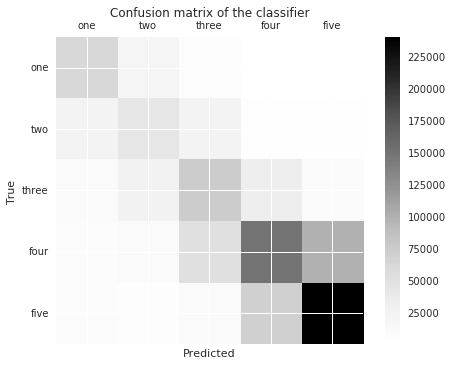

In [66]:
pipeline = Pipeline([
    ('vectorizer',  CountVectorizer(stop_words='english', ngram_range=(1,2),
                                   max_df=0.5, min_df=100)),
   # ('transformer', TfidfTransformer(use_idf=False)),
    ('classifier',  MultinomialNB(fit_prior=False)) ])

k_fold = KFold(n=len(reviews), n_folds=2)
scores = []
confusion = np.zeros(shape=(5,5))
for train_indices, test_indices in k_fold:
    train_text = reviews.iloc[train_indices]['Text'].values
    train_y = reviews.iloc[train_indices]['Rating_nom'].values

    test_text = reviews.iloc[test_indices]['Text'].values
    test_y = reviews.iloc[test_indices]['Rating_nom'].values

    pipeline.fit(train_text, train_y)
    predictions = pipeline.predict(test_text)

    confusion += confusion_matrix(test_y, predictions, 
                                  labels = labels)
    print(metrics.classification_report(test_y, predictions, labels = labels))
print('Total reviews classified:', len(reviews))
#print('Score:', sum(scores)/len(scores))
print('Confusion matrix:')
print(confusion)
plot_confusion(confusion)

             precision    recall  f1-score   support

        one       0.65      0.69      0.67     43983
        two       0.47      0.37      0.42     48605
      three       0.49      0.38      0.43     76837
       four       0.54      0.56      0.55    159890
       five       0.66      0.74      0.70    165999

avg / total       0.58      0.59      0.58    495314

             precision    recall  f1-score   support

        one       0.64      0.70      0.67     43230
        two       0.48      0.36      0.41     48971
      three       0.49      0.38      0.43     76785
       four       0.54      0.57      0.55    159648
       five       0.66      0.73      0.70    166679

avg / total       0.58      0.59      0.58    495313

Total reviews classified: 990627
Confusion matrix:
[[  60634.   15689.    4803.    3557.    2530.]
 [  22267.   35866.   25100.   10637.    3706.]
 [   6613.   18404.   58084.   57829.   12692.]
 [   2579.    4300.   25505.  181118.  106036.]
 [   1589

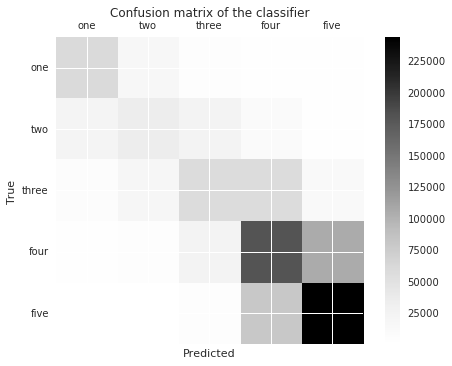

In [67]:
#from time import time
#reviews_500K = reviews.sample(n = 500000)
#t0 = time()
pipeline = Pipeline([
    ('vectorizer',  CountVectorizer(ngram_range=(1,2), stop_words='english',
                                   max_df=0.5, min_df=100)),
    ('transformer', TfidfTransformer(use_idf=True)),
    ('classifier',  LinearSVC()) ])

k_fold = KFold(n=len(reviews), n_folds=2)
scores = []
confusion = np.zeros(shape=(5,5))
for train_indices, test_indices in k_fold:
    train_text = reviews.iloc[train_indices]['Text'].values
    train_y = reviews.iloc[train_indices]['Rating_nom'].values

    test_text = reviews.iloc[test_indices]['Text'].values
    test_y = reviews.iloc[test_indices]['Rating_nom'].values

    pipeline.fit(train_text, train_y)
    predictions = pipeline.predict(test_text)

    confusion += confusion_matrix(test_y, predictions, 
                                  labels = labels)
    print(metrics.classification_report(test_y, predictions, labels = labels))

print('Total reviews classified:', len(reviews))
#print('SVM with two fold cross validation on 150000 reviews took (min):', (time()-t0)/60)
print('Confusion matrix:')
print(confusion)
plot_confusion(confusion)